# Applying Machine Learning (Advanced)

### Author: Mohammed A. Shehab

# Outline

- [ 1 - Packages ](#1)
- [ 2 - Polynomial Regression ](#2)
- [ 3 - Bias and Variance](#3)
- [ 4- Tuning Regularization](#4)
- [ 5- Evaluating a Deep Learning Algorithm (Neural Network)](#5)
    - [5.1- Dataset](#5.1)
    - [5.2- Model Complexity](#5.2)
    - [5.3- Complex model results](#5.3)
    - [5.4- Simple model results](#5.4)
    - [5.5- Regularized-Model results](#5.5)
- [6- Compared results of all three models](#6) 

<a name="1"></a>
## Packages 

First, let\'s run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [94]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

<a name="2"></a>
## Polynomial Regression

<!-- <a name="2.1"></a> -->
### Splitting the dataset

We will split the dataset as 66% for training and 33% for testing. . Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [95]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


### Visualize the dataset

In the following code, we polt the training data in red, while the testing blue. This particular dataset is a quadratic function with noise added. The "ideal" curve is shown for reference.

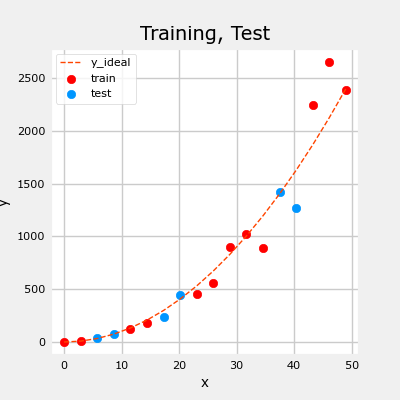

In [96]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.grid(True)
plt.show()

### Error calculation for model evaluation, linear regression

When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

In [97]:
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err+=(y[i]-yhat[i])**2
    err/= 2*m
    
    return(err)

### Compare performance on training and test data

Let's build a high degree polynomial model to minimize training error. This will use the `linear_regression` functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:

- Create and fit the model. ('fit' is another name for training or running gradient descent).
- Compute the error on the training data.
- Compute the error on the test data.
set.

In [99]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

In [100]:
print(f"Training err {err_train:0.3f}, test err {err_test:0.3f}")

Training err 58.008, test err 171215.012


The plot below illustrates this phenomenon. The model fits the training data exceptionally well by creating a highly complex function. However, when it comes to predicting on the test data, which was not used during training, the model performs poorly. This scenario is characteristic of a model that:

- Overfits the training data.
- Has high variance.
- Generalizes poorly to new, unseen data.

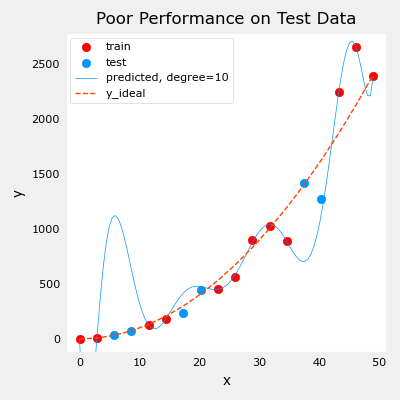

In [101]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)
# plt.grid(True)
plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error indicates that this model is unlikely to perform well on new data. If you use the test error to guide improvements in the model, the model may perform well on the test data, but this defeats the purpose because the test data is meant to represent new, unseen data. To properly evaluate the model's performance on new data, you need yet another set of data.

The proposed approach, as discussed in the lecture, is to divide the data into three groups: training, cross-validation, and test sets. The distribution shown in the table below is typical, but it can be adjusted depending on the amount of data available.

| Dataset              | Purpose                                                    | Ratio   |
|----------------------|------------------------------------------------------------|---------|
| Training Set         | Used for training the model                                | 60%     |
| Cross-Validation Set | Used for tuning hyperparameters and model selection        | 20%     |
| Test Set             | Used for evaluating the model's performance on new data    | 20%     |



In [102]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
### Bias and Variance



To choose a good value for the degree of the polynomial model, you can use the training and cross-validation performance as guidance. By trying a range of degree values and evaluating the training and cross-validation performance, you can determine the degree that provides the best balance between complexity and generalization.

As shown in the diagram, as the degree of the polynomial model increases, the training performance typically improves. However, at some point, increasing the degree too much can lead to overfitting, where the model becomes too complex and performs poorly on new data. This is reflected in the cross-validation performance, which may start to degrade relative to the training performance as the degree becomes too large.

To find the best degree value for your model, you can plot the training and cross-validation performance as a function of the degree and choose the degree that gives the best cross-validation performance without overfitting.

### Visualize the dataset as Train, Cross-Validation, Test

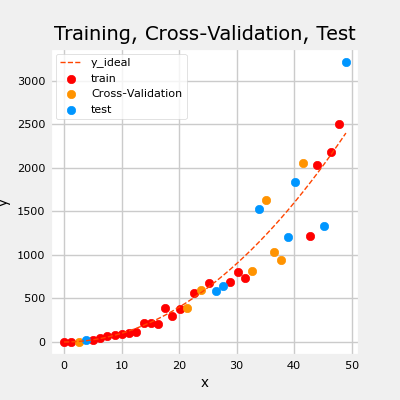

In [103]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Cross-Validation, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="Cross-Validation")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.grid(True)
plt.show()

### Finding the optimal degree

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [104]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

### Visualize the results

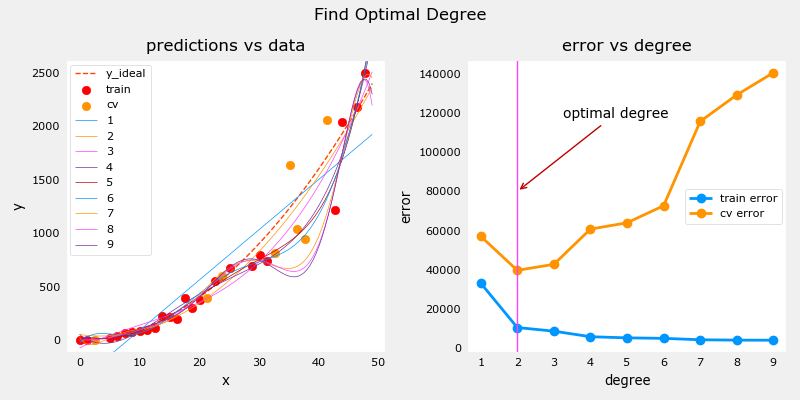

In [105]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above illustrates the concept of using two groups of data - one for training the model and another for evaluating its performance - to determine if the model is underfitting or overfitting. In this example, a range of polynomial models is created by varying the degree of the polynomial used, from **underfitting (degree 1)** to **overfitting (maximum degree)**.

In the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree polynomial hews very closely to every data point.

In the right plot:
- The error on the trained data (blue) decreases as the model complexity increases, as expected.
- The error on the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to overfit on the training data and fails to generalize.

It's important to note that while the curves in these examples may not be as smooth as ideal, the general trend is what's important. The specific data points assigned to each group can significantly change the results, but the overall concept remains valid.

<a name="4"></a>
### Tuning Regularization

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [106]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

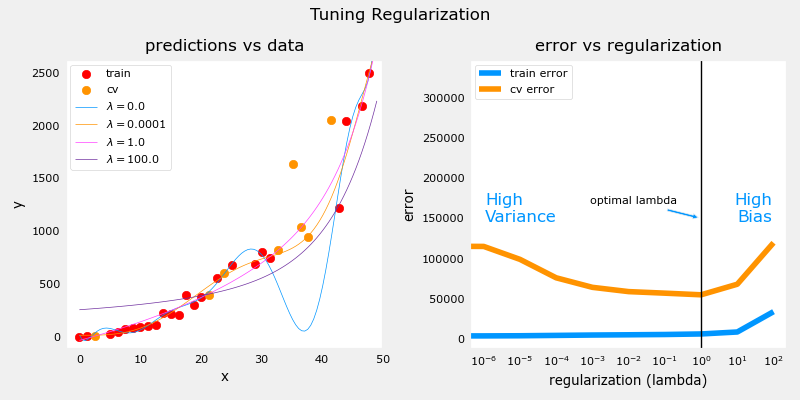

In [107]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

### Increase the dataset size

When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

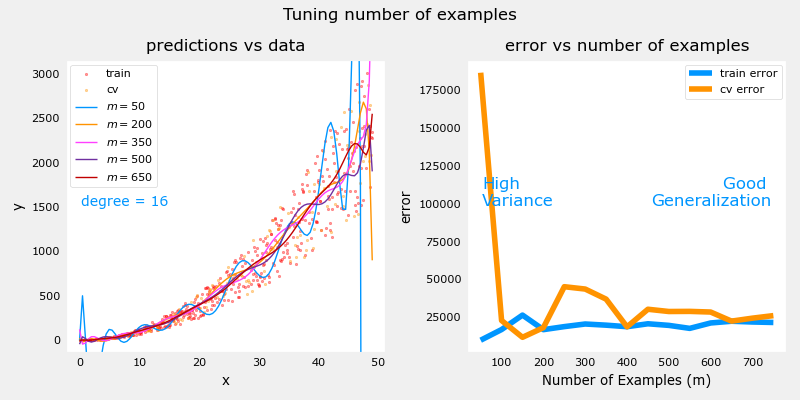

In [108]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The plots above demonstrate that when a model has high variance and is overfitting, adding more examples can improve its performance. In the left plot, the final curve with the highest value of *𝑚* (number of examples) is a smooth curve that fits in the center of the data, indicating improved generalization.

On the right plot, as the number of examples increases, the performance of both the training set and cross-validation set tends to converge to similar values. This convergence indicates that the model is becoming more stable and is generalizing better to new data.

It's important to note that the curves in these plots may not be perfectly smooth, which is expected in real-world scenarios. However, the overall trend is clear: adding more data improves the model's ability to generalize and reduces overfitting.

> **Note**: that adding more examples when the model has high bias (underfitting) does not improve performance.

<a name="5"></a>
## Evaluating a Deep Learning Algorithm (Neural Network)

<a name="5.1"></a>
### Data Set

1. Training 50%
2. Validation 40%
3. Testing 10%

In [109]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


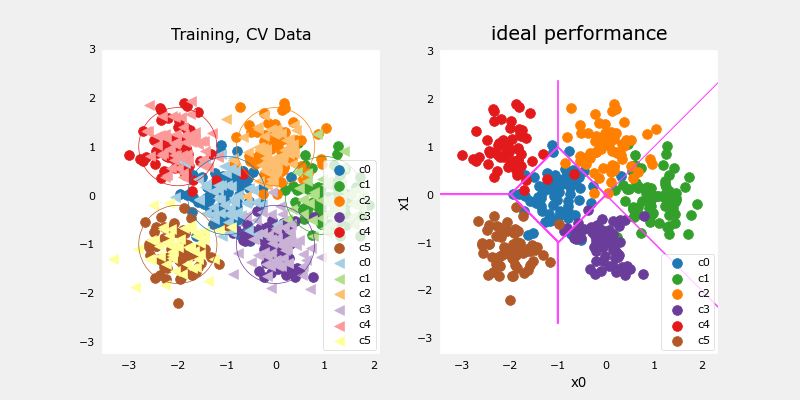

In [110]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

On the left, the data is shown with six clusters identified by color. Both training points (dots) and cross-validation points (triangles) are displayed. Points in ambiguous locations, where either cluster might consider them members, are particularly interesting.

For a neural network model, you would expect it to try to find patterns in the data to classify points into the correct clusters. In ambiguous regions, the model might struggle and could potentially misclassify some points.

An example of overfitting in this scenario would be if the neural network created complex boundaries that perfectly separate each cluster in the training data but fail to generalize well to new data, leading to misclassification in the cross-validation set.

Underfitting, on the other hand, would occur if the neural network created overly simplistic boundaries that fail to capture the true structure of the data, resulting in poor performance on both the training and cross-validation sets.

On the right, there is an example of an 'ideal' model that one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. This model would "misclassify" roughly 8% of the total data set, which is acceptable given the complexity of the data and the boundaries.

### Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

In [73]:
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
       if(yhat[i]!=y[i]):
            incorrect+=1
    cerr=incorrect/m
    return(cerr)

In [74]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )


categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250


<a name="5.2"></a>
## Model Complexity

We want to build two models:
1. **Complex model**
2. **Simple model**

### Complex model structure

* Dense layer with 120 units, relu activation.
* Dense layer with 40 units, relu activation.
* Dense layer with 6 units and a linear activation (not softmax) 
Compile usin loss with *SparseCategoricalCrossentropy*.
* Adam optimizer with learning rate of 0.01.g

In [75]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        tf.keras.layers.Dense(120, activation="relu"),
        tf.keras.layers.Dense(40, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")

    ], name="Complex"
)
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [76]:
# start model here
model.fit(
    X_train, y_train,
    epochs=1000)

Epoch 1/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.0872
Epoch 2/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4296
Epoch 3/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3229
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2744
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2506
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2709
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2339
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2259
Epoch 9/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2279
Epoch 10/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1972
Epoch 11/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2146
Epoch 12/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2049
Epoch 13/1000
13/13 [====

In [77]:
model.summary()

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 120)               360       
                                                                 
 dense_33 (Dense)            (None, 40)                4840      
                                                                 
 dense_34 (Dense)            (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________


<a id="5.3"></a>

1082/1082 [==============================] - 1s 1ms/step


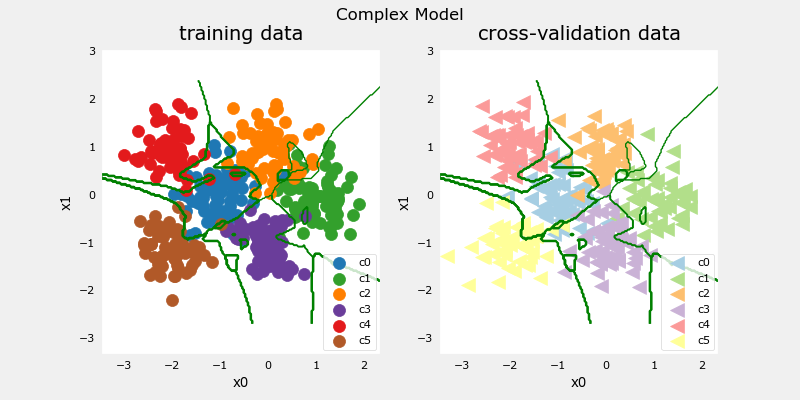

In [112]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has made significant efforts to capture outliers in each category, leading to misclassification of some cross-validation data. 

See the classification error below:

In [79]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 2ms/step
categorization error, training, complex model: 0.003
categorization error, cv,       complex model: 0.122


### Simple model

* Dense layer with 6 units, relu activation.
* Dense layer with 6 units and a linear activation (not softmax) Compile using loss with *SparseCategoricalCrossentropy*.
* Adam optimizer with learning rate of 0.01.

In [113]:
tf.random.set_seed(1234)
model_s = Sequential(
    [
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear"),
        
    ], name = "Simple"
)
model_s.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)


In [81]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

model_s.fit(
    X_train,y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.5966
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.3503
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.1648
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9886
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8046
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6442
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5296
Epoch 8/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4447
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3928
Epoch 10/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3559
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3301
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3134
Epoch 13/1000
13/13 [====

In [82]:
model_s.summary()

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 6)                 18        
                                                                 
 dense_36 (Dense)            (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


<a id="5.4"></a>

1082/1082 [==============================] - 1s 975us/step


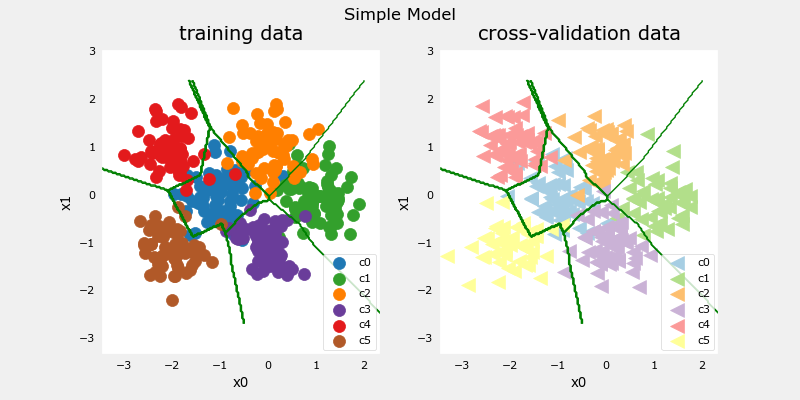

In [111]:
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [84]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 1ms/step
categorization error, training, simple model, 0.070, complex model: 0.003
categorization error, cv,       simple model, 0.081, complex model: 0.122


### Regularization affect

In [85]:
tf.random.set_seed(1234)
model_r = Sequential(
    [
        tf.keras.layers.Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(6, activation="linear"),
    ], name= "Regularization-Model"
)
model_r.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)


In [86]:
model_r.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
13/13 [==============================] - 0s 5ms/step - loss: 4.3988
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.5806
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.2582
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.0409
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9813
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9440
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9448
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.8688
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.8156
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.7702
Epoch 11/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.7548
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.7537
Epoch 13/1000
13/13 [====

In [87]:
model_r.summary()

Model: "Regularization-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 120)               360       
                                                                 
 dense_38 (Dense)            (None, 40)                4840      
                                                                 
 dense_39 (Dense)            (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________


<a id="5.5"></a>

1082/1082 [==============================] - 1s 1ms/step


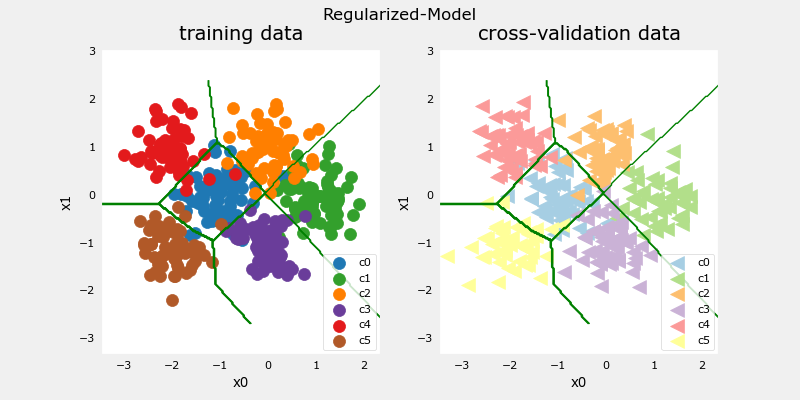

In [88]:
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized-Model")

> The results look very similar to the 'ideal' model.

In [89]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 2ms/step
categorization error, training, regularized: 0.065, simple model, 0.070, complex model: 0.003
categorization error, cv,       regularized: 0.066, simple model, 0.081, complex model: 0.122


As we can see, the Regularized-Model perform better than complex one, but it still lower than simple model. The affect of Regularization improve the complex model performance.

### Iterate to find optimal regularization value

In [90]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2]
models=[None] * len(lambdas)

for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.0166
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4170
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3213
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2791
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2732
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2852
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2418
Epoch 8/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2223
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2282
Epoch 10/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2024
Epoch 11/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2162
Epoch 12/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2041
Epoch 13/1000
13/13 [====

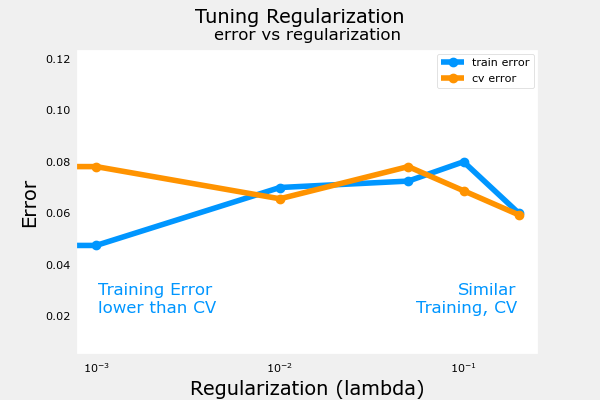

In [114]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

<a id="6"></a>

3/3 [==============================] - 0s 1ms/step


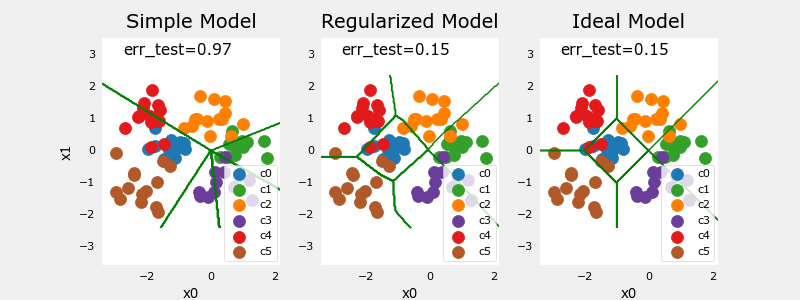

In [115]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Copyright © 2024 Mohammed A. Shehab. All Rights Reserved.